# Project 7

## Data Cleaning

Largely inspired by this workbook: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction#Introduction:-Home-Credit-Default-Risk-Competition

<b>Dataset Description</b>: application_train/application_test: The main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.

<b>Project Objective</b>
1. Design a model that will give a probability of a client defaulting on a loan
2. Create a dashboard aimed at client managers that will allow easy interpretation of the model and to allow client managers to better understand their clients

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.linear_model import LogisticRegression

# SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from collections import Counter

import sys
sys.path.insert(0,"../data")
sys.path.insert(0,"../models")

import pickle

import lime
import lime.lime_tabular

In [2]:
# Set up environment
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
plt.rcParams['figure.figsize'] = [14, 6]

In [3]:
# Training data
app_train = pd.read_csv('../data/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [4]:
# Testing data features
app_test = pd.read_csv('../data/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

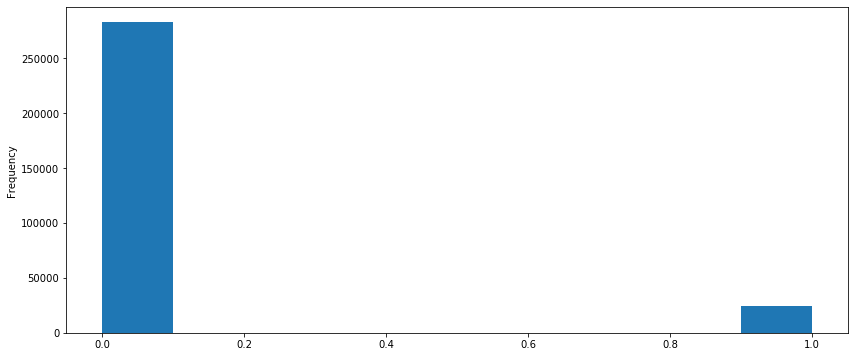

In [5]:
# Examine distribution of target column
app_train['TARGET'].astype(int).plot.hist();

In [6]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

We are dealing with an imbalanced problem. This will be resolved using SMOTE later on.

### Encoding

We will use label encoding for every feature that has 2 categories and one-hot encoding for features with more than 2 categories.

In [7]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [8]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [9]:
# Create train labels
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
# When we do the align, we must make sure to set axis = 1 to align the dataframes based on the columns and not on the rows!
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


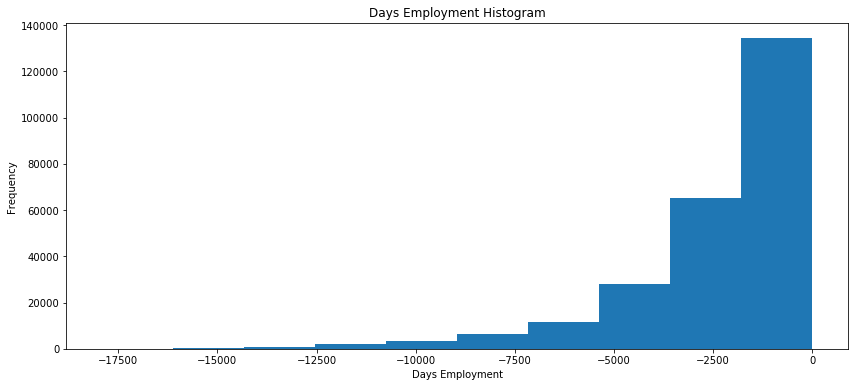

In [10]:
# Dealing with issues in the Employment column
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [11]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


In [12]:
# Adding domain-specific features
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [13]:
# Adding domain-specific features
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

In [14]:
print('Training Features shape: ', app_train_domain.shape)
print('Testing Features shape: ', app_test_domain.shape)

Training Features shape:  (307511, 245)
Testing Features shape:  (48744, 244)


In [15]:
app_train_domain.info(verbose = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 245 columns):
 #   Column                                             Dtype  
---  ------                                             -----  
 0   SK_ID_CURR                                         int64  
 1   NAME_CONTRACT_TYPE                                 int64  
 2   FLAG_OWN_CAR                                       int64  
 3   FLAG_OWN_REALTY                                    int64  
 4   CNT_CHILDREN                                       int64  
 5   AMT_INCOME_TOTAL                                   float64
 6   AMT_CREDIT                                         float64
 7   AMT_ANNUITY                                        float64
 8   AMT_GOODS_PRICE                                    float64
 9   REGION_POPULATION_RELATIVE                         float64
 10  DAYS_BIRTH                                         int64  
 11  DAYS_EMPLOYED                                      

In [16]:
app_train_domain.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002                   0             0                1   
1      100003                   0             0                0   
2      100004                   1             1                1   
3      100006                   0             0                1   
4      100007                   0             0                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461         -637.0            -3648.0   
1                    0.003541      -16765        -1188.0            -1186.0   
2                    0.010032      -19046         -225.0            -4260.0   
3                    0.008019      -19005        -3039.0            -9833.0   
4                    0.028663      -19932        -3038.0            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              1.0   
1                 1           1           0              2.0   
2                 1           1           0              1.0   
3                 1           0           0              2.0   
4                 1           0           0              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.083037   
1                       0                        0      0.311267   
2                       0                        0           NaN   
3                       0                        0           NaN   
4                       1                        1           NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.262949      0.139376          0.0247            0.0369   
1      0.622246           NaN   

### Data Integrity Checks

In [17]:
# Count of children
app_train_domain['CNT_CHILDREN'].value_counts()

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
19         2
12         2
10         2
9          2
8          2
11         1
Name: CNT_CHILDREN, dtype: int64

In [18]:
# Drop all records with more than 7 children
app_train_domain = app_train_domain[app_train_domain['CNT_CHILDREN'] <=7]

In [19]:
#app_train_domain.to_csv('../data/unscaled_data.csv')

In [36]:
unscaled_data_columns = ['SK_ID_CURR', 'TARGET', 'AMT_CREDIT']
unscaled_data = app_train_domain[unscaled_data_columns]
unscaled_data.to_csv('../data/unscaled_data_small.csv')

In [34]:
app_train_domain_sample = app_train_domain.sample(int(len(app_train_domain)*0.1))

In [ ]:
app_train_domain_sample.to_csv('')

## Building Models

### Prep full data

In [20]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 

# Create train labels
train_labels = app_train_domain['TARGET']

# Drop the target from the training data
#if 'TARGET' in app_train_domain:
#    train = app_train_domain.drop(columns = ['TARGET'])
#else:
#    train = app_train_domain.copy()

train = app_train_domain.copy()

# Drop the IDs and record them for later
train_ids = train['SK_ID_CURR']
train.drop(columns = ['SK_ID_CURR'], inplace = True)

# Feature names
features = list(train.columns)

# Median imputation of missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)

print('Training data shape: ', train.shape)

Training data shape:  (307497, 244)


In [21]:
# Recreate a data frame from the training dataset
df_final = pd.DataFrame(train, columns = features)

In [22]:
df_final['SK_ID_CURR'] = train_ids

In [23]:
df_final

NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0                      0.0           0.0              1.0           0.0   
1                      0.0           0.0              0.0           0.0   
2                      1.0           1.0              1.0           0.0   
3                      0.0           0.0              1.0           0.0   
4                      0.0           0.0              1.0           0.0   
...                    ...           ...              ...           ...   
307492                 0.0           0.0              0.0           0.0   
307493                 0.0           0.0              1.0           0.0   
307494                 0.0           0.0              1.0           0.0   
307495                 0.0           0.0              1.0           0.0   
307496                 0.0           0.0              0.0           0.0   

        AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0               0.001512    0.090287     0.090032         0.077441   
1               0.002089    0.311736     0.132924         0.271605   
2               0.000358    0.022472     0.020025         0.023569   
3               0.000935    0.066837     0.109477         0.063973   
4               0.000819    0.116854     0.078975         0.117845   
...                  ...         ...          ...              ...   
307492          0.001127    0.052360     0.101176         0.046016   
307493          0.000396    0.056067     0.040505         0.046016   
307494          0.001089    0.157969     0.110618         0.135802   
307495          0.001243    0.081175     0.072499         0.069585   
307496          0.001127    0.157303     0.185258         0.158249   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                         0.256321    0.888839       0.964437   
1                         0.045016    0.477114       0.933676   
2                         0.134897    0.348534       0.987439   
3                         0.107023    0.350846       0.830337   
4                         0.392880    0.298591       0.830393   
...                            ...         ...            ...   
307492                    0.446855    0.896392       0.986824   
307493                    0.344429    0.251071       0.907995   
307494                    0.065247    0.578523       0.557782   
307495                    0.069553    0.747914       0.732805   
307496                    0.635991    0.471984       0.929544   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0                0.852140         0.705433     0.098901         1.0   
1                0.951929         0.959566     0.098901         1.0   
2                0.827335         0.648326     0.285714         1.0   
3                0.601451         0.661387     0.098901         1.0   
4                0.825268         0.519522     0.098901         1.0   
...                   ...              ...          ...         ...   
307492           0.657263         0.724607     0.098901         1.0   
307493           0.822147         0.431708     0.098901         1.0   
307494           0.726937         0.284424     0.098901         1.0   
307495           0.896158         0.870641     0.098901         1.0   
307496           0.792153         0.943032     0.098901         1.0   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0                  1.0              0.0               1.0         1.0   
1                  1.0              0.0               1.0         1.0   
2                  1.0              1.0               1.0         1.0   
3                  1.0              0.0               1.0         0.0   
4                  1.0              0.0               1.0         0.0   
...                ...              ...               ...         ...   
307492             1.0              0.0               1.0         0.0   
307493             0.0              0.0         

In [27]:
df_final_sample = df_final.sample(n = int(len(df_final)*0.1))

In [29]:
df_final_sample.to_csv('../data/df_final_sample.csv')

In [190]:
#df_final.to_csv('../data/df_final.csv')

In [35]:
train_final_sample = df_final_sample.drop()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30749 entries, 76366 to 131252
Columns: 245 entries, NAME_CONTRACT_TYPE to SK_ID_CURR
dtypes: float64(245)
memory usage: 57.7 MB


In [30]:
train.drop(columns = ['TARGET'], inplace = True)

AttributeError: 'numpy.ndarray' object has no attribute 'drop'

In [21]:
from collections import Counter
Counter(train_labels)

Counter({1: 24822, 0: 282675})

In [22]:
# Create a split between test and train datasets to find model performance
#X_train, X_test, y_train, y_test = train_test_split(train, train_labels, test_size=0.25, random_state=42)

In [61]:
# Define a dataframe to store the results of our different models
results = pd.DataFrame(columns = ['model','score', 'train_score', 'test_score'])

# Create F-Beta scorer
f_beta = make_scorer(fbeta_score, beta=2)

# Define the two scoring techniques for our models
scoring = {'F-Beta': f_beta,
           'ROC AUC': 'roc_auc'}

## Dealing with Imbalanced Learning

### SMOTE

As we saw earlier, we are clearly dealing with an imbalanced learning problem here, we will try to address this using SMOTE. According to the article and the original paper, the best strategy is to use a combination of over and under-sampling by over-sampling to reach a certain threshold and then under-sampling to match that threshold to a 1:2 level. This will also reduce the number of observations in our dataset.

Inspiration: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

### Logistic Regression

#### NO SMOTE

In [189]:
# Define model
model = LogisticRegression(random_state = 42)

# Number of cross-validations
cv = 5

# Cross-Validated scores
scores = cross_validate(model, train, train_labels, cv=cv, scoring=scoring, return_train_score=True, verbose = 1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   41.4s finished


In [191]:
model.fit(train, train_labels)

LogisticRegression(random_state=42)

In [62]:
# Get average score
train_score_f_beta = scores['train_F-Beta'].sum() / cv
test_score_f_beta = scores['test_F-Beta'].sum() / cv
train_score_roc_auc = scores['train_ROC AUC'].sum() / cv
test_score_roc_auc = scores['test_ROC AUC'].sum() / cv

# Append results to table
results = results.append({'model': 'Logistic Regression',
                          'score': 'F-Beta',
                          'train_score': train_score_f_beta,
                          'test_score': test_score_f_beta
                         }, ignore_index = True)

results = results.append({'model': 'Logistic Regression',
                          'score': 'ROC AUC',
                          'train_score': train_score_roc_auc,
                          'test_score': test_score_roc_auc
                         }, ignore_index = True)

In [ ]:
score_accuracy

In [63]:
results

model    score  train_score  test_score
0  Logistic Regression   F-Beta     0.014368    0.013818
1  Logistic Regression  ROC AUC     0.749265    0.746488

In [193]:
from sklearn.metrics import classification_report,accuracy_score 
print(classification_report(train_labels, model.predict)) 
print(accuracy_score(y_test, y_pred))

TypeError: Expected sequence or array-like, got <class 'method'>

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score()

Confusion matrix, without normalization
[[282383    292]
 [ 24537    285]]
Normalized confusion matrix
[[1.   0.  ]
 [0.99 0.01]]


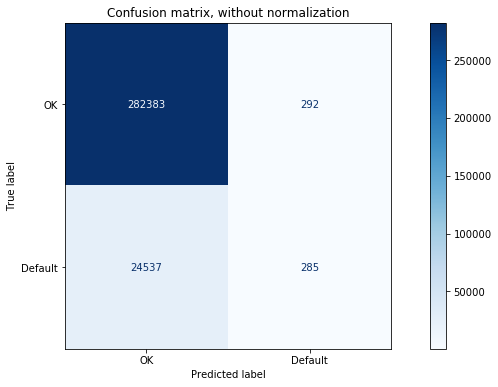

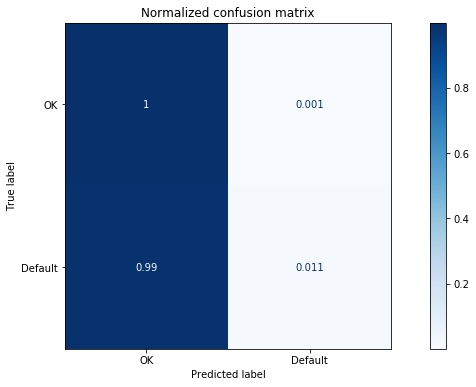

In [192]:
from sklearn.metrics import plot_confusion_matrix

np.set_printoptions(precision=2)

class_names = np.array(['OK','Default'])

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, train, train_labels,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

#### With SMOTE

In [31]:
# Define model
model = LogisticRegression(random_state = 42)

# Define pipeline
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)

# Parameter grid
parameters = {'model__penalty': ['l1', 'l2']}

# Hyperparameter Tuning
log_reg_search = GridSearchCV(estimator = pipeline, 
                              param_grid = parameters,
                              cv = 3, 
                              verbose = 3,
                              n_jobs = -1, 
                              scoring = f_beta
                             )

#Variable 1
log_reg_tuned = log_reg_search.fit(train, train_labels)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  3.3min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  3.4min finished


In [69]:
# Append results to table
results = results.append({'model': 'Logistic Regression',
                          'score': 'F-Beta',
                          #'train_score': log_reg_tuned.cv_results_['mean_train_score'][1],
                          'test_score': log_reg_tuned.best_score_
                         }, ignore_index = True)

In [70]:
results

model    score  train_score  test_score
0  Logistic Regression   F-Beta     0.014368    0.013818
1  Logistic Regression  ROC AUC     0.749265    0.746488
2  Logistic Regression   F-Beta          NaN    0.349521

In [39]:
# Serialize model
pickle.dump(log_reg_tuned, open('../models/LRModel2.obj', 'wb'))

### XG Boost

In [40]:
from xgboost import XGBClassifier

# Define model
xgb = XGBClassifier(objective='binary:logistic')

# Define pipeline
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', xgb)]
pipeline = Pipeline(steps=steps)

# Parameter grid
parameters = {'model__max_depth': [3,4]}

# Hyperparameter Tuning
xgb_search = GridSearchCV(estimator = pipeline, 
                              param_grid = parameters,
                              cv = 3, 
                              verbose = 3,
                              n_jobs = -1, 
                              scoring = f_beta
                             )

#Variable 1
xgbtuned = xgb_search.fit(train, train_labels)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  6.2min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  6.3min finished


In [71]:
# Append results to table
results = results.append({'model': 'XG Boost',
                          'score': 'F-Beta',
                          #'train_score': xgbtuned.cv_results_['mean_train_score'][1],
                          'test_score': xgbtuned.best_score_
                         }, ignore_index = True)

In [72]:
results

model    score  train_score  test_score
0  Logistic Regression   F-Beta     0.014368    0.013818
1  Logistic Regression  ROC AUC     0.749265    0.746488
2  Logistic Regression   F-Beta          NaN    0.349521
3             XG Boost   F-Beta          NaN    0.100488

In [ ]:
# Serialize model
pickle.dump(xgbtuned, open('../models/XGBModel3.obj', 'wb'))

### Light Gradient Boosting

In [75]:
import lightgbm as lgb

# Define model
lgbm = lgb.LGBMClassifier(n_estimators = 1000, objective = 'binary', is_unbalance = True, random_state = 42)

# Define pipeline
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', lgbm)]
pipeline = Pipeline(steps=steps)

# Parameter grid
parameters = {'model__learning_rate': [0.02,0.05]}

# Hyperparameter Tuning
lgbm_search = GridSearchCV(estimator = pipeline, 
                              param_grid = parameters,
                              cv = 3, 
                              verbose = 3,
                              n_jobs = -1, 
                              scoring = f_beta
                             )

#Variable 1
lgbm_tuned = lgbm_search.fit(train, train_labels)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  7.1min remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  7.3min finished


In [78]:
# Append results to table
results = results.append({'model': 'Light Gradient Boosting',
                          'score': 'F-Beta',
                          #'train_score': xgbtuned.cv_results_['mean_train_score'][1],
                          'test_score': lgbm_tuned.best_score_
                         }, ignore_index = True)

In [79]:
results

model    score  train_score  test_score
0      Logistic Regression   F-Beta     0.014368    0.013818
1      Logistic Regression  ROC AUC     0.749265    0.746488
2      Logistic Regression   F-Beta          NaN    0.349521
3                 XG Boost   F-Beta          NaN    0.100488
4                 XG Boost   F-Beta          NaN    0.100488
5  Light Gradient Boosting   F-Beta          NaN    0.256886

In [ ]:
# Serialize model
pickle.dump(lgbm_tuned, open('../models/LGBModel2.obj', 'wb'))

#### Random Forest

In [80]:
from sklearn.ensemble import RandomForestClassifier

# Define model
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)

# Define pipeline
over = SMOTE(sampling_strategy=0.3)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', rfc)]
pipeline = Pipeline(steps=steps)

# Parameter grid
parameters = {'model__min_samples_split': [2,3]}

# Hyperparameter Tuning
rfc_search = GridSearchCV(estimator = pipeline, 
                              param_grid = parameters,
                              cv = 3, 
                              verbose = 3,
                              n_jobs = -1, 
                              scoring = f_beta
                             )

#Variable 1
rfc_tuned = rfc_search.fit(train, train_labels)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  5.3min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  5.3min finished


In [81]:
# Append results to table
results = results.append({'model': 'Random Forest Classifier',
                          'score': 'F-Beta',
                          #'train_score': xgbtuned.cv_results_['mean_train_score'][1],
                          'test_score': rfc_tuned.best_score_
                         }, ignore_index = True)

In [82]:
results

model    score  train_score  test_score
0       Logistic Regression   F-Beta     0.014368    0.013818
1       Logistic Regression  ROC AUC     0.749265    0.746488
2       Logistic Regression   F-Beta          NaN    0.349521
3                  XG Boost   F-Beta          NaN    0.100488
4                  XG Boost   F-Beta          NaN    0.100488
5   Light Gradient Boosting   F-Beta          NaN    0.256886
6  Random Forest Classifier   F-Beta          NaN    0.039227

In [ ]:
# Serialize model
pickle.dump(rfc_tuned, open('../models/RFCModel2.obj', 'wb'))

### Dashboard Graphs

In [83]:
dashboard_df = pd.read_csv('../data/application_train.csv')

In [84]:
dashboard_df.info(verbose = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   SK_ID_CURR                    int64  
 1   TARGET                        int64  
 2   NAME_CONTRACT_TYPE            object 
 3   CODE_GENDER                   object 
 4   FLAG_OWN_CAR                  object 
 5   FLAG_OWN_REALTY               object 
 6   CNT_CHILDREN                  int64  
 7   AMT_INCOME_TOTAL              float64
 8   AMT_CREDIT                    float64
 9   AMT_ANNUITY                   float64
 10  AMT_GOODS_PRICE               float64
 11  NAME_TYPE_SUITE               object 
 12  NAME_INCOME_TYPE              object 
 13  NAME_EDUCATION_TYPE           object 
 14  NAME_FAMILY_STATUS            object 
 15  NAME_HOUSING_TYPE             object 
 16  REGION_POPULATION_RELATIVE    float64
 17  DAYS_BIRTH                    int64  
 18  DAYS_EMPLOYED          

In [85]:
dashboard_df['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [86]:
# For a particular column eg. EXT_SOURCE_1, get the average for different groups
dashboard_df['overall_avg'] = dashboard_df['EXT_SOURCE_1'].mean()
dashboard_df['default_avg'] = dashboard_df[dashboard_df['TARGET'] == 1]['EXT_SOURCE_1'].mean()
dashboard_df['ok_avg'] = dashboard_df[dashboard_df['TARGET'] == 0]['EXT_SOURCE_1'].mean()

In [87]:
# Features to graph
ft_list = ['EXT_SOURCE_1', 'overall_avg', 'default_avg', 'ok_avg']

In [88]:
graph = dashboard_df[dashboard_df['SK_ID_CURR'] == 100002][ft_list]

<BarContainer object of 4 artists>

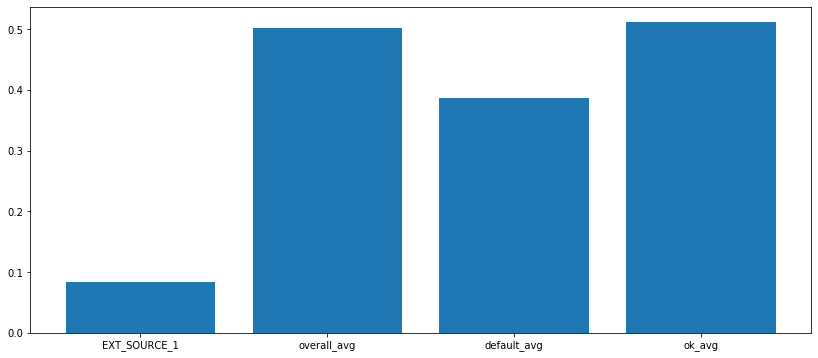

In [89]:
plt.bar(graph.columns.tolist(), graph.values.tolist()[0])

### LIME

In [2]:
import pickle
model = pickle.load(open('../models/LRModel2.obj','rb'))

In [3]:
model

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('over', SMOTE(sampling_strategy=0.3)),
                                       ('under',
                                        RandomUnderSampler(sampling_strategy=0.5)),
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1, param_grid={'model__penalty': ['l1', 'l2']},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=3)

In [ ]:
import pickle
model_xgb = pickle.load(open('../models/XGBModel.obj','rb'))

In [ ]:
model_xgb

In [4]:
import lime
import lime.lime_tabular

In [7]:
lime_df = pd.read_csv('../data/train_final.csv')

In [40]:
X = lime_df[lime_df['SK_ID_CURR'] == 100003]
X.drop(columns = ['SK_ID_CURR'], inplace = True)
model.predict_proba(X)[:, 1][0]
#model.predict(X)

0.11042385169002793

In [41]:
rest_of_df = lime_df.drop(columns = ['SK_ID_CURR'])

In [42]:
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = np.array(rest_of_df.sample(int(0.1*rest_of_df.shape[0]), random_state=20)),
                                                   feature_names = rest_of_df.columns,
                                                   training_labels = rest_of_df.columns.tolist(),
                                                   verbose=1,
                                                   random_state=20,
                                                   mode='classification'
                                                  )

In [43]:
exp = explainer.explain_instance(data_row = X.to_numpy().ravel(),
                                 predict_fn = model.predict_proba)#,
                                 #num_features = 5)

Intercept -0.15232371713888754
Prediction_local [0.29047306]
Right: 0.11042385169002793


In [44]:
exp.show_in_notebook(show_table = True)

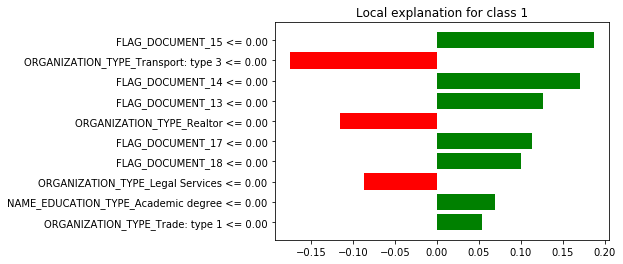

In [45]:
# Generate pyplot figure
fig = exp.as_pyplot_figure()

In [46]:
exp.as_list()

[('FLAG_DOCUMENT_15 <= 0.00', 0.18742209870698745),
 ('ORGANIZATION_TYPE_Transport: type 3 <= 0.00', -0.17555901424291565),
 ('FLAG_DOCUMENT_14 <= 0.00', 0.17087319365485235),
 ('FLAG_DOCUMENT_13 <= 0.00', 0.12606485082182228),
 ('ORGANIZATION_TYPE_Realtor <= 0.00', -0.11562905428103593),
 ('FLAG_DOCUMENT_17 <= 0.00', 0.11302055302568788),
 ('FLAG_DOCUMENT_18 <= 0.00', 0.10024570107429497),
 ('ORGANIZATION_TYPE_Legal Services <= 0.00', -0.08661181609919077),
 ('NAME_EDUCATION_TYPE_Academic degree <= 0.00', 0.06962789236013274),
 ('ORGANIZATION_TYPE_Trade: type 1 <= 0.00', 0.053342367370379465)]

In [47]:
def clean_map(string):
    '''nettoyage des caractères de liste en sortie de LIME as_list'''
    signes = ['=>', '<=', '<', '>']
    for signe in signes :
        if signe in string :
            signe_confirme = signe
        string = string.replace(signe, '____')
    string = string.split('____')
    if string[0][-1] == ' ':
        string[0] = string[0][:-1]

    return (string, signe_confirme)

In [48]:
df_map = pd.DataFrame(exp.as_list())
print(df_map)

                                             0         1
0                     FLAG_DOCUMENT_15 <= 0.00  0.187422
1  ORGANIZATION_TYPE_Transport: type 3 <= 0.00 -0.175559
2                     FLAG_DOCUMENT_14 <= 0.00  0.170873
3                     FLAG_DOCUMENT_13 <= 0.00  0.126065
4            ORGANIZATION_TYPE_Realtor <= 0.00 -0.115629
5                     FLAG_DOCUMENT_17 <= 0.00  0.113021
6                     FLAG_DOCUMENT_18 <= 0.00  0.100246
7     ORGANIZATION_TYPE_Legal Services <= 0.00 -0.086612
8  NAME_EDUCATION_TYPE_Academic degree <= 0.00  0.069628
9      ORGANIZATION_TYPE_Trade: type 1 <= 0.00  0.053342


In [49]:
df_map['feature'] = df_map[0].apply(lambda x : clean_map(x)[0][0])
df_map['signe'] = df_map[0].apply(lambda x : clean_map(x)[1])
df_map['val_lim'] = df_map[0].apply(lambda x: clean_map(x)[0][-1])
#df_map['ecart'] = df_map[0].apply(lambda x: clean_map(x)[0][-1])
df_map['ecart'] = df_map[1]

df_map = df_map[['feature', 'signe', 'val_lim', 'ecart']]
#global
df_map['contribution'] = 'normal'
df_map.loc[df_map['ecart']>=0, 'contribution'] = 'default'

In [50]:
df_map

feature signe val_lim     ecart contribution
0                     FLAG_DOCUMENT_15    <=    0.00  0.187422      default
1  ORGANIZATION_TYPE_Transport: type 3    <=    0.00 -0.175559       normal
2                     FLAG_DOCUMENT_14    <=    0.00  0.170873      default
3                     FLAG_DOCUMENT_13    <=    0.00  0.126065      default
4            ORGANIZATION_TYPE_Realtor    <=    0.00 -0.115629       normal
5                     FLAG_DOCUMENT_17    <=    0.00  0.113021      default
6                     FLAG_DOCUMENT_18    <=    0.00  0.100246      default
7     ORGANIZATION_TYPE_Legal Services    <=    0.00 -0.086612       normal
8  NAME_EDUCATION_TYPE_Academic degree    <=    0.00  0.069628      default
9      ORGANIZATION_TYPE_Trade: type 1    <=    0.00  0.053342      default

In [51]:
df_map['customer_values'] = [X[feature].mean() for feature in df_map['feature'].values.tolist()]

In [58]:
rest_of_df['TARGET']

KeyError: 'TARGET'

In [52]:
df_map

feature signe val_lim     ecart contribution  \
0                     FLAG_DOCUMENT_15    <=    0.00  0.187422      default   
1  ORGANIZATION_TYPE_Transport: type 3    <=    0.00 -0.175559       normal   
2                     FLAG_DOCUMENT_14    <=    0.00  0.170873      default   
3                     FLAG_DOCUMENT_13    <=    0.00  0.126065      default   
4            ORGANIZATION_TYPE_Realtor    <=    0.00 -0.115629       normal   
5                     FLAG_DOCUMENT_17    <=    0.00  0.113021      default   
6                     FLAG_DOCUMENT_18    <=    0.00  0.100246      default   
7     ORGANIZATION_TYPE_Legal Services    <=    0.00 -0.086612       normal   
8  NAME_EDUCATION_TYPE_Academic degree    <=    0.00  0.069628      default   
9      ORGANIZATION_TYPE_Trade: type 1    <=    0.00  0.053342      default   

   customer_values  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  
5              0.0  
6              0.0  
7              0.0  
8              0.0  
9              0.0

In [56]:
df_map['moy_global'] = [rest_of_df[feature].mean() for feature in df_map['feature'].values.tolist()]
df_map['moy_en_regle'] = [rest_of_df[rest_of_df['TARGET'] == 0][feature].mean() for feature in df_map['feature'].values.tolist()]
#clients en règle
df_map['moy_defaut'] = [rest_of_df[rest_of_df['TARGET'] == 1][feature].mean() for feature in df_map['feature'].values.tolist()]

KeyError: 'TARGET'

In [54]:
df_map

feature signe val_lim     ecart contribution  \
0                     FLAG_DOCUMENT_15    <=    0.00  0.187422      default   
1  ORGANIZATION_TYPE_Transport: type 3    <=    0.00 -0.175559       normal   
2                     FLAG_DOCUMENT_14    <=    0.00  0.170873      default   
3                     FLAG_DOCUMENT_13    <=    0.00  0.126065      default   
4            ORGANIZATION_TYPE_Realtor    <=    0.00 -0.115629       normal   
5                     FLAG_DOCUMENT_17    <=    0.00  0.113021      default   
6                     FLAG_DOCUMENT_18    <=    0.00  0.100246      default   
7     ORGANIZATION_TYPE_Legal Services    <=    0.00 -0.086612       normal   
8  NAME_EDUCATION_TYPE_Academic degree    <=    0.00  0.069628      default   
9      ORGANIZATION_TYPE_Trade: type 1    <=    0.00  0.053342      default   

   customer_values  moy_global  
0              0.0    0.001210  
1              0.0    0.003860  
2              0.0    0.002937  
3              0.0    0.003525  
4              0.0    0.001288  
5              0.0    0.000267  
6              0.0    0.008130  
7              0.0    0.000992  
8              0.0    0.000533  
9              0.0    0.001132

In [ ]:

df_map['moy_en_regle'] = [dataframe_complet[dataframe_complet['LABELS'] == 0][feature].mean() for feature in df_map['feature'].values.tolist()]
#clients en règle
df_map['moy_defaut'] = [dataframe_complet[dataframe_complet['LABELS'] == 1][feature].mean() for feature in df_map['feature'].values.tolist()]
#20 plus proches voisins
index_plus_proches_voisins = nearest_neighbors(X, dataframe_complet, 20)
df_map['moy_voisins'] = [dataframe_complet[dataframe_complet['Unnamed: 0'].isin(index_plus_proches_voisins)][feature].mean() for feature in df_map['feature'].values.tolist()]

#### Getting the feature names out of LIME for future reference

In [31]:
lime_results = pd.DataFrame(exp.as_list())

In [32]:
lime_results

0         1
0                     FLAG_DOCUMENT_15 <= 0.00  0.187422
1  ORGANIZATION_TYPE_Transport: type 3 <= 0.00 -0.175559
2                     FLAG_DOCUMENT_14 <= 0.00  0.170873
3                     FLAG_DOCUMENT_13 <= 0.00  0.126065
4            ORGANIZATION_TYPE_Realtor <= 0.00 -0.115629
5                     FLAG_DOCUMENT_17 <= 0.00  0.113021
6                     FLAG_DOCUMENT_18 <= 0.00  0.100246
7     ORGANIZATION_TYPE_Legal Services <= 0.00 -0.086612
8  NAME_EDUCATION_TYPE_Academic degree <= 0.00  0.069628
9      ORGANIZATION_TYPE_Trade: type 1 <= 0.00  0.053342

In [21]:
lime_results = lime_results[0].to_list()

In [22]:
lime_results

['EXT_SOURCE_3 <= 0.47',
 'EXT_SOURCE_2 <= 0.46',
 '0.00 < FLAG_DOCUMENT_3 <= 1.00',
 'FLAG_OWN_CAR <= 0.00',
 'EXT_SOURCE_1 <= 0.52']

In [171]:
for i, feature in enumerate(lime_results):
    signs = ['=>', '<=', '<', '>']
    #print(i)
    ## Need to go through 4 iterations of this split, one for each sign, where if the resulting length is 1, you keep going, otherwise you end it there
    lime_results[i] = lime_results[i].split()
    for sign in signs:
        #print(sign)
        #print(sign in lime_results[i])
        if sign in lime_results[i]:
            lime_results[i].remove(sign)

In [188]:
for i, feature in enumerate(lime_results):
    signs = ['=>', '<=', '<', '>']
    #print(i)
    ## Need to go through 4 iterations of this split, one for each sign, where if the resulting length is 1, you keep going, otherwise you end it there
    for j in signs:
        print(j)
        if j in lime_results[i]:
            lime_results[i].split(' '+ j +' ')
            print(lime_results[i])
        for sign in signs:
            #print(sign)
            #print(sign in lime_results[i])
            if sign in lime_results[i]:
                lime_results[i].remove(sign)

=>


AttributeError: 'str' object has no attribute 'remove'

In [182]:
for i, feature in enumerate(lime_results):
    if len(feature) == 2:
        lime_results[i] = lime_results[i][0]
    elif len(feature) == 3:
        lime_results[i] = lime_results[i][1]

In [183]:
lime_results

['EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'FLAG_DOCUMENT_3',
 'EXT_SOURCE_1',
 ['0.00',
  'NAME_EDUCATION_TYPE_Secondary',
  '/',
  'secondary',
  'special',
  '1.00']]

In [105]:
app_train_domain[lime_results]

EXT_SOURCE_3  EXT_SOURCE_2  FLAG_DOCUMENT_3  FLAG_OWN_CAR  \
0           0.139376      0.262949                1             0   
1                NaN      0.622246                1             0   
2           0.729567      0.555912                0             1   
3                NaN      0.650442                1             0   
4                NaN      0.322738                0             0   
...              ...           ...              ...           ...   
307506           NaN      0.681632                0             0   
307507           NaN      0.115992                1             0   
307508      0.218859      0.535722                1             0   
307509      0.661024      0.514163                1             0   
307510      0.113922      0.708569                1             0   

        EXT_SOURCE_1  
0           0.083037  
1           0.311267  
2                NaN  
3                NaN  
4                NaN  
...              ...  
307506      0.145570  
307507           NaN  
307508      0.744026  
307509           NaN  
307510      0.734460  

[307497 rows x 5 columns]

In [106]:
credit_df = app_train_domain.pivot_table('AMT_CREDIT', 'SK_ID_CURR').sort_values(by = 'AMT_CREDIT', ascending = False).head(20)

In [107]:
y_pos = credit_df.sort_values(by = 'AMT_CREDIT').index.astype(str)
credit_amount = credit_df.sort_values(by = 'AMT_CREDIT')['AMT_CREDIT']

In [108]:
default_df = app_train_domain.pivot_table('SK_ID_CURR', 'TARGET', aggfunc = 'count')

In [109]:
default_df

SK_ID_CURR
TARGET            
0           282675
1            24822

<BarContainer object of 2 artists>

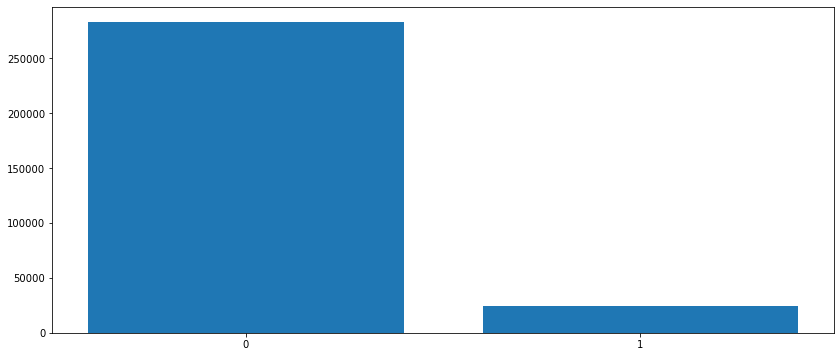

In [110]:
plt.bar(default_df.index.astype(str), default_df['SK_ID_CURR'])

### Confusion Matrix

Confusion matrix, without normalization
[[247537  35138]
 [ 14697  10125]]
Normalized confusion matrix
[[0.88 0.12]
 [0.59 0.41]]


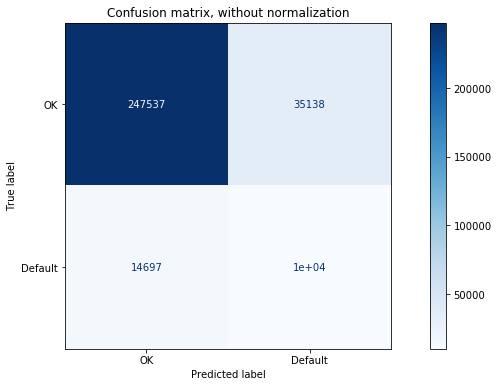

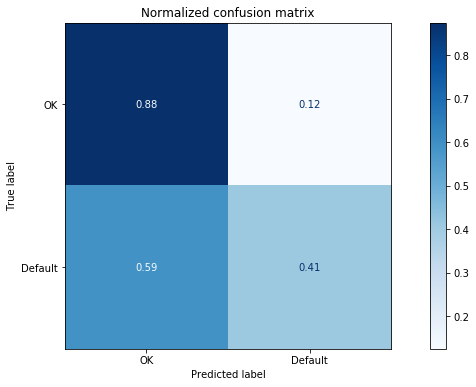

In [59]:
from sklearn.metrics import plot_confusion_matrix

np.set_printoptions(precision=2)

class_names = np.array(['OK','Default'])

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(log_reg_tuned, train, train_labels,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

### Nearest Neighbours

In [67]:
from sklearn.neighbors import KDTree

In [68]:
cols = ['DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'CODE_GENDER_F', 'CREDIT_TERM', 'CREDIT_INCOME_PERCENT']

In [69]:
neighbours_df = rest_of_df[cols]

In [70]:
kdt = KDTree(neighbours_df, leaf_size=30, metric='euclidean')

In [77]:
pickle.dump(kdt, open('../models/kdtree.obj', 'wb'))

In [71]:
dist, ind = kdt.query(np.array(X[cols]).reshape(1,-1), k = 10)

In [78]:
nn_idx = ind[0]

In [85]:
nn_idx

array([     1, 170065, 211494,  16690,  89470, 231501, 291579,  51342,
       217737, 277075])

In [88]:
# Filter on the nearest neighbours
rest_of_df[rest_of_df.index.isin(nn_idx)][cols]

DAYS_BIRTH  AMT_INCOME_TOTAL  CODE_GENDER_F  CREDIT_TERM  \
1         0.477114          0.002089            1.0     0.053985   
16690     0.478918          0.000473            1.0     0.056204   
51342     0.480552          0.002281            1.0     0.053840   
89470     0.475423          0.001974            1.0     0.054134   
170065    0.476099          0.002089            1.0     0.053024   
211494    0.475085          0.004012            1.0     0.053547   
217737    0.477170          0.002858            1.0     0.053823   
231501    0.472210          0.002089            1.0     0.054039   
277075    0.470970          0.001320            1.0     0.054560   
291579    0.472266          0.002281            1.0     0.053969   

        CREDIT_INCOME_PERCENT  
1                    0.056483  
16690                0.058051  
51342                0.061088  
89470                0.051913  
170065               0.055019  
211494               0.056627  
217737               0.050627  
231501               0.054861  
277075               0.052963  
291579               0.054414

### Interpretation

In [295]:
# Import dataset
df_final = pd.read_csv('../data/df_final.csv')

In [192]:
# Generate sample of data for faster processing

# Define sample size
#sample_size = 0.1
#
## Generate reduced dataset
#data_sample = df_final.sample(n = int(len(df_final)*sample_size))

In [294]:
# Print out examples of regular and default clients
normal_sample = df_final[df_final['TARGET'] == 0]['SK_ID_CURR'].sample(5).tolist()
print("Examples of clients not at risk:")
for i in range(0, len(normal_sample)): 
    normal_sample[i] = int(normal_sample[i])
str(normal_sample).replace('[','').replace(']', '')
    
default_sample = df_final[df_final['TARGET'] == 1]['SK_ID_CURR'].sample(5).tolist()
print("Examples of clients at risk of default:")
for client in default_sample:
    print(int(client))

Examples of clients not at risk:
Examples of clients at risk of default:
444506
415844
229430
143189
130033


In [296]:
# Import model

import pickle
model = pickle.load(open('../models/LRModel2.obj','rb'))
kdt = pickle.load(open('../models/kdtree.obj','rb'))

In [297]:
# Filter the dataset on a single ID
X = df_final[df_final['SK_ID_CURR'] == 171811]

# Drop columns not used in the training of the model
X.drop(columns = ['SK_ID_CURR', 'TARGET', 'Unnamed: 0'], inplace = True)

# Get probability of defaulting
pred = model.predict_proba(X)[:, 1][0]
pred = round(pred, 2)*100

if pred >50:
    print(f'This client is at risk of defaulting on their loan. Probability of default is {pred}%.')
else:
    print(f'This client has a low risk of defaulting. Probability of default is {pred}%.')

This client has a low risk of defaulting. Probability of default is 24.0%.


In [298]:
# Generate dataset without unrequired columns
df_lime = df_final.drop(columns = ['SK_ID_CURR', 'TARGET', 'Unnamed: 0'])

In [301]:
# Generate explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = np.array(df_lime.sample(int(0.1*df_lime.shape[0]), random_state=20)),
                                                   feature_names = df_lime.columns,
                                                   training_labels = df_lime.columns.tolist(),
                                                   verbose=1,
                                                   random_state=20,
                                                   mode='classification'
                                                  )

In [302]:
# Generate specific instance explainer
exp = explainer.explain_instance(data_row = X.to_numpy().ravel(),
                                 predict_fn = model.predict_proba)

Intercept -0.08754905482962022
Prediction_local [0.18288445]
Right: 0.2409604330609478


In [308]:
X.to_numpy().ravel().shape

(243,)

In [211]:
exp.show_in_notebook(show_table = True)

In [310]:
arr = np.array([], dtype=np.int64) 

In [312]:
arr[0] = 23   

IndexError: index 0 is out of bounds for axis 0 with size 0

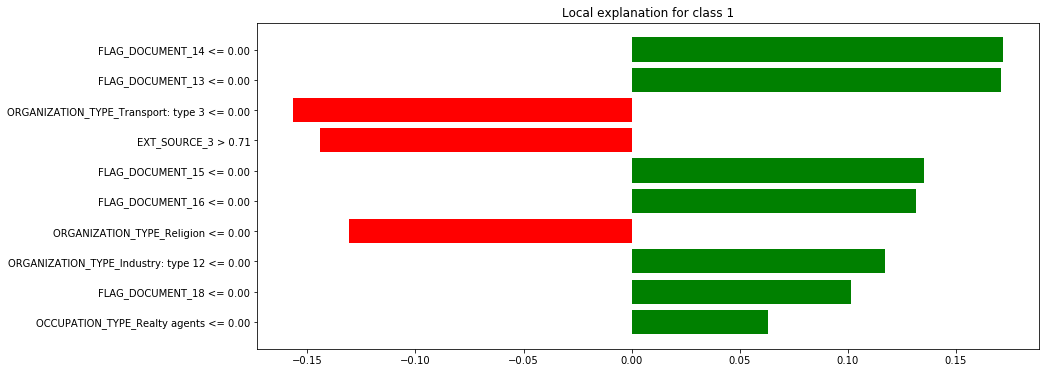

In [212]:
# Generate pyplot figure
fig = exp.as_pyplot_figure()

In [220]:
def clean_lime_output(string):
    '''nettoyage des caractères de liste en sortie de LIME as_list'''
    signes = ['=>', '<=', '<', '>']
    for signe in signes :
        if signe in string :
            signe_confirme = signe
        string = string.replace(signe, '____')
    string = string.split('____')
    if string[0][-1] == ' ':
        string[0] = string[0][:-1]

    return (string, signe_confirme)

In [248]:
# Generate dataframe based on Lime output
df_interpret = pd.DataFrame(exp.as_list())

In [249]:
# Clean up the format of the data frame
df_interpret['feature'] = df_interpret[0].apply(lambda x : clean_lime_output(x)[0][0])
df_interpret['sign'] = df_interpret[0].apply(lambda x : clean_lime_output(x)[1])
df_interpret['limit_value'] = df_interpret[0].apply(lambda x: clean_lime_output(x)[0][-1])
df_interpret['difference'] = df_interpret[1]

# Rename columns
df_interpret = df_interpret[['feature', 'sign', 'limit_value', 'difference']]


df_interpret['contribution'] = 'normal'
df_interpret.loc[df_interpret['difference']>=0, 'contribution'] = 'default'

In [250]:
df_interpret

feature sign limit_value  difference  \
0                     FLAG_DOCUMENT_14   <=        0.00    0.171734   
1                     FLAG_DOCUMENT_13   <=        0.00    0.170783   
2  ORGANIZATION_TYPE_Transport: type 3   <=        0.00   -0.156724   
3                         EXT_SOURCE_3    >        0.71   -0.144011   
4                     FLAG_DOCUMENT_15   <=        0.00    0.135234   
5                     FLAG_DOCUMENT_16   <=        0.00    0.131395   
6           ORGANIZATION_TYPE_Religion   <=        0.00   -0.130934   
7  ORGANIZATION_TYPE_Industry: type 12   <=        0.00    0.117015   
8                     FLAG_DOCUMENT_18   <=        0.00    0.101258   
9        OCCUPATION_TYPE_Realty agents   <=        0.00    0.063041   

  contribution  
0      default  
1      default  
2       normal  
3       normal  
4      default  
5      default  
6       normal  
7      default  
8      default  
9      default

In [251]:
# Add the customer's value for each feature
df_interpret['customer_value'] = [X[feature].mean() for feature in df_interpret['feature'].values.tolist()]

# Global average
df_interpret['global_average'] = [df_final[feature].mean() for feature in df_interpret['feature'].values.tolist()]

# Non-default average
df_interpret['non_default_average'] = [df_final[df_final['TARGET'] == 0][feature].mean() for feature in df_interpret['feature'].values.tolist()]

# Average of defaulting clients
df_interpret['default_average'] = [df_final[df_final['TARGET'] == 1][feature].mean() for feature in df_interpret['feature'].values.tolist()]

In [252]:
# Average of closest neighbours

# Columns considered in determining closest neighbours
cols = ['DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'CODE_GENDER_F', 'CREDIT_TERM', 'CREDIT_INCOME_PERCENT']
# Choose number of neighbours
neighbours = 10
# Get the IDs of the n closest neighbours
dist, ind = kdt.query(np.array(X[cols]).reshape(1,-1), k = neighbours)
nn_idx = ind[0]
# Generate a n neighbours dataset
nn_df = df_final[df_final.index.isin(nn_idx)]
# Average of nearest neighbours
df_interpret['similar_clients_average'] = [nn_df[feature].mean() for feature in df_interpret['feature'].values.tolist()]

In [255]:
nn_df['EXT_SOURCE_3']

4614      0.706328
24619     0.772803
28493     0.597163
85352     0.914357
97047     0.371111
103954    0.362223
109815    0.417086
163230    0.312974
205784    0.794687
222939    0.897123
Name: EXT_SOURCE_3, dtype: float64

In [254]:
df_interpret

feature sign limit_value  difference  \
0                     FLAG_DOCUMENT_14   <=        0.00    0.171734   
1                     FLAG_DOCUMENT_13   <=        0.00    0.170783   
2  ORGANIZATION_TYPE_Transport: type 3   <=        0.00   -0.156724   
3                         EXT_SOURCE_3    >        0.71   -0.144011   
4                     FLAG_DOCUMENT_15   <=        0.00    0.135234   
5                     FLAG_DOCUMENT_16   <=        0.00    0.131395   
6           ORGANIZATION_TYPE_Religion   <=        0.00   -0.130934   
7  ORGANIZATION_TYPE_Industry: type 12   <=        0.00    0.117015   
8                     FLAG_DOCUMENT_18   <=        0.00    0.101258   
9        OCCUPATION_TYPE_Realty agents   <=        0.00    0.063041   

  contribution  customer_value  global_average  non_default_average  \
0      default        0.000000        0.002937             0.003088   
1      default        0.000000        0.003525             0.003729   
2       normal        0.000000        0.003860             0.003538   
3       normal        0.794687        0.575298             0.584312   
4      default        0.000000        0.001210             0.001277   
5      default        0.000000        0.009925             0.010270   
6       normal        0.000000        0.000276             0.000283   
7      default        0.000000        0.001200             0.001256   
8      default        0.000000        0.008130             0.008342   
9      default        0.000000        0.002442             0.002448   

   default_average  similar_clients_average  
0         0.001209                 0.000000  
1         0.001209                 0.000000  
2         0.007534                 0.000000  
3         0.472647                 0.614586  
4         0.000443                 0.000000  
5         0.006003                 0.000000  
6         0.000201                 0.000000  
7         0.000564                 0.000000  
8         0.005721                 0.000000  
9         0.002377                 0.000000

In [258]:
df_interpret = pd.concat([df_interpret[df_interpret['contribution'] == 'default'].head(3),
                     df_interpret[df_interpret['contribution'] == 'normal'].head(3)], axis=0)

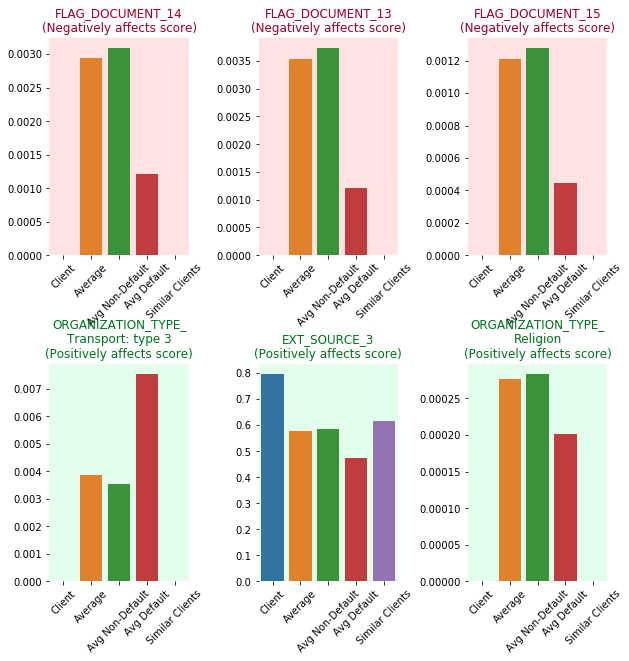

In [263]:
# Generating 2 rows and 3 columns of graphs
f, ax = plt.subplots(2, 3, figsize=(10,10), sharex=False)
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)

i = 0
j = 0
liste_cols = ['Client', 'Average', 'Avg Non-Default', 'Avg Default','Similar Clients']
for feature in df_interpret['feature']:

    sns.despine(ax=None, left=True, bottom=True, trim=False)
    sns.barplot(y = df_interpret[df_interpret['feature']==feature][['customer_value', 'global_average', 'non_default_average', 'default_average', 'similar_clients_average']].values[0],
               x = liste_cols,
               ax = ax[i, j])
    sns.axes_style("white")

    if len(feature) >= 18:
        chaine = feature[:18]+'\n'+feature[18:]
    else : 
        chaine = feature
    if df_interpret[df_interpret['feature']==feature]['contribution'].values[0] == 'default':
        chaine += '\n(Negatively affects score)'
        ax[i,j].set_facecolor('#ffe3e3') #contribue négativement
        ax[i,j].set_title(chaine, color='#990024')
    else:
        chaine += '\n(Positively affects score)'
        ax[i,j].set_facecolor('#e3ffec')
        ax[i,j].set_title(chaine, color='#017320')


    if j == 2:
        i+=1
        j=0
    else:
        j+=1
    if i == 2:
        break;
for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
if i!=2: #Cases without enough features to explain (ex : 445260)
    True

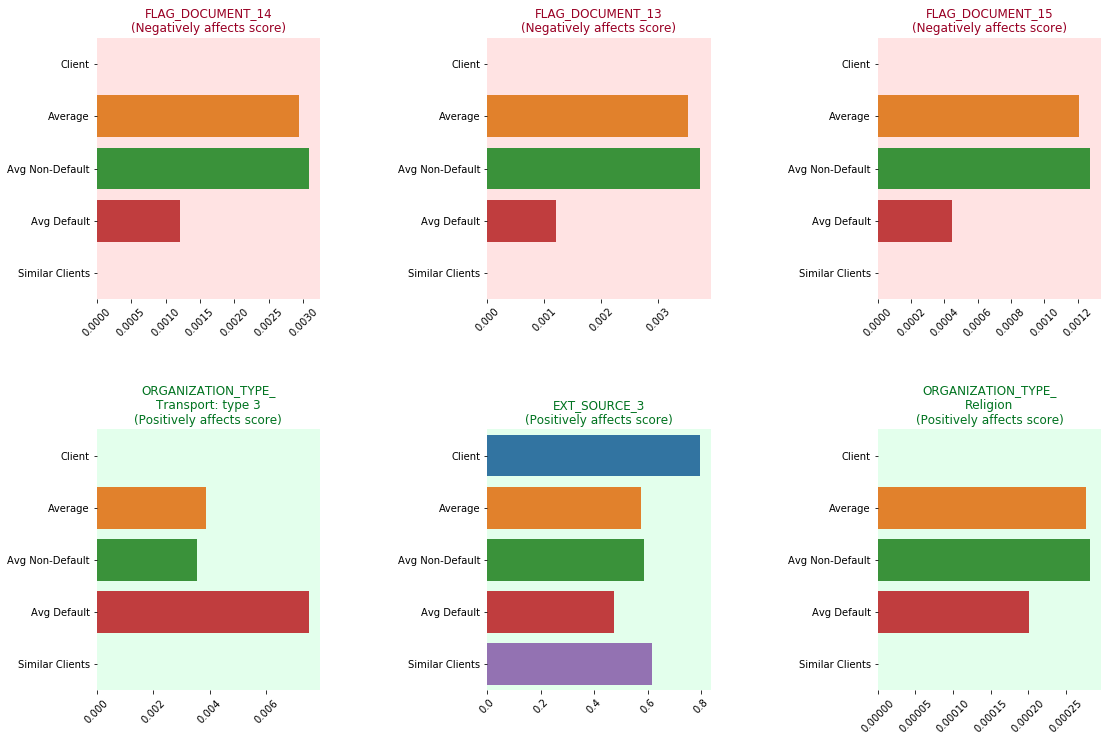

In [270]:
# Generating 2 rows and 3 columns of graphs
f, ax = plt.subplots(2, 3, figsize=(18,12), sharex=False)
plt.subplots_adjust(hspace = 0.5, wspace = 0.75)

i = 0
j = 0
liste_cols = ['Client', 'Average', 'Avg Non-Default', 'Avg Default','Similar Clients']
for feature in df_interpret['feature']:

    sns.despine(ax=None, left=True, bottom=True, trim=False)
    sns.barplot(x = df_interpret[df_interpret['feature']==feature][['customer_value', 'global_average', 'non_default_average', 'default_average', 'similar_clients_average']].values[0],
               y = liste_cols,
               ax = ax[i, j])
    sns.axes_style("white")

    if len(feature) >= 18:
        chaine = feature[:18]+'\n'+feature[18:]
    else : 
        chaine = feature
    if df_interpret[df_interpret['feature']==feature]['contribution'].values[0] == 'default':
        chaine += '\n(Negatively affects score)'
        ax[i,j].set_facecolor('#ffe3e3') #contribue négativement
        ax[i,j].set_title(chaine, color='#990024')
    else:
        chaine += '\n(Positively affects score)'
        ax[i,j].set_facecolor('#e3ffec')
        ax[i,j].set_title(chaine, color='#017320')


    if j == 2:
        i+=1
        j=0
    else:
        j+=1
    if i == 2:
        break;
for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
if i!=2: #Cases without enough features to explain (ex : 445260)
    True

In [ ]:
def graphes_streamlit(df):
    '''A partir du dataframe, affichage un subplot de 6 graphes représentatif du client comparé à d'autres clients sur 6 features'''
    f, ax = plt.subplots(2, 3, figsize=(10,10), sharex=False)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    
    i = 0
    j = 0
    liste_cols = ['Client', 'Moyenne', 'En Règle', 'En défaut','Similaires']
    for feature in df['feature']:

        sns.despine(ax=None, left=True, bottom=True, trim=False)
        sns.barplot(y = df[df['feature']==feature][['customer_values', 'moy_global', 'moy_en_regle', 'moy_defaut', 'moy_voisins']].values[0],
                   x = liste_cols,
                   ax = ax[i, j])
        sns.axes_style("white")

        if len(feature) >= 18:
            chaine = feature[:18]+'\n'+feature[18:]
        else : 
            chaine = feature
        if df[df['feature']==feature]['contribution'].values[0] == 'default':
            chaine += '\n(pénalise le score)'
            ax[i,j].set_facecolor('#ffe3e3') #contribue négativement
            ax[i,j].set_title(chaine, color='#990024')
        else:
            chaine += '\n(améliore le score)'
            ax[i,j].set_facecolor('#e3ffec')
            ax[i,j].set_title(chaine, color='#017320')
            
       
        if j == 2:
            i+=1
            j=0
        else:
            j+=1
        if i == 2:
            break;
    for ax in f.axes:
        plt.sca(ax)
        plt.xticks(rotation=45)
    if i!=2: #cas où on a pas assez de features à expliquer (ex : 445260)
        #
        True
    st.pyplot()

    return True

In [273]:
# Filter the dataset on a single ID
test = df_final[df_final['SK_ID_CURR'] == 100003]

# Drop columns not used in the training of the model
test.drop(columns = ['SK_ID_CURR', 'TARGET', 'Unnamed: 0'], inplace = True)


In [274]:
model.predict_proba(test)

array([[0.88957615, 0.11042385]])